# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
!pip install basemap==2.0.0
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# EDA


## Data Reading & Input

In [ ]:
# Melihat 5 baris pertama dataset
df = pd.read_csv('/content/drive/MyDrive/Machine Learning Datasets/Tugas Kuliah/Proyek akhir mata kuliah IoT, Machine Learning, & Sistem Pakar/IoT_Indoor_Air_Quality_Dataset.csv')
df.head()

,Timestamp,Temperature (?C),Humidity (%),CO2 (ppm),PM2.5 (?g/m?),PM10 (?g/m?),TVOC (ppb),CO (ppm),Light Intensity (lux),Motion Detected,Occupancy Count,Ventilation Status
0,18-02-2024 08:00,21.75,63.11,989.74,31.17,89.66,226.83,2.84,646.86,0.0,49.0,Open
1,18-02-2024 08:05,27.51,68.03,924.59,27.32,44.82,116.76,3.12,845.45,1.0,11.0,Open
2,18-02-2024 08:10,25.32,53.51,604.05,73.84,71.08,56.59,3.59,560.03,1.0,29.0,Closed
3,18-02-2024 08:15,23.99,58.52,692.20,62.94,10.90,228.06,2.66,499.84,1.0,28.0,Closed
4,18-02-2024 08:20,19.56,69.34,533.12,26.56,88.06,267.26,1.76,411.36,1.0,16.0,Closed


In [ ]:
# Menghapus kolom-kolom yang tidak diperlukan
df.drop(columns=['CO2 (ppm)', 'PM10 (?g/m?)', 'CO (ppm)', 'Light Intensity (lux)', 'Motion Detected', 'Occupancy Count', 'Ventilation Status'], inplace=True)
df.head()

,Timestamp,Temperature (?C),Humidity (%),PM2.5 (?g/m?),TVOC (ppb)
0,18-02-2024 08:00,21.75,63.11,31.17,226.83
1,18-02-2024 08:05,27.51,68.03,27.32,116.76
2,18-02-2024 08:10,25.32,53.51,73.84,56.59
3,18-02-2024 08:15,23.99,58.52,62.94,228.06
4,18-02-2024 08:20,19.56,69.34,26.56,267.26


In [ ]:
df.rename(columns={'Temperature (?C)': 'Temperature (°C)'}, inplace=True)
df.rename(columns={'PM2.5 (?g/m?)': 'PM2.5 (µg/m³)'}, inplace=True)
df.head()

,Timestamp,Temperature (°C),Humidity (%),PM2.5 (µg/m³),TVOC (ppb)
0,18-02-2024 08:00,21.75,63.11,31.17,226.83
1,18-02-2024 08:05,27.51,68.03,27.32,116.76
2,18-02-2024 08:10,25.32,53.51,73.84,56.59
3,18-02-2024 08:15,23.99,58.52,62.94,228.06
4,18-02-2024 08:20,19.56,69.34,26.56,267.26


In [ ]:
# Melihat deskripsi data
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97458 entries, 0 to 97457
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Timestamp         97458 non-null  object 
 1   Temperature (°C)  95509 non-null  float64
 2   Humidity (%)      95509 non-null  float64
 3   PM2.5 (µg/m³)     95509 non-null  float64
 4   TVOC (ppb)        95509 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.7+ MB


,Temperature (°C),Humidity (%),PM2.5 (µg/m³),TVOC (ppb)
count,95509.000000,95509.000000,95509.000000,95509.000000
mean,22.995823,50.043729,39.931032,274.884291
std,2.884487,11.541731,20.198692,129.801995
min,18.000000,30.000000,5.000000,50.000000
25%,20.500000,40.040000,22.430000,162.740000
50%,23.010000,50.060000,39.850000,273.910000
75%,25.500000,60.000000,57.430000,387.230000
max,28.000000,70.000000,75.000000,500.000000


In [ ]:
# Memeriksa jumlah data yang kosong
df.isnull().sum()

,0
Timestamp,0
Temperature (°C),1949
Humidity (%),1949
PM2.5 (µg/m³),1949
TVOC (ppb),1949


## Data Cleaning

In [ ]:
# Menghapus baris dengan data kosong
df.dropna(inplace=True)
df.isnull().sum()

,0
Timestamp,0
Temperature (°C),0
Humidity (%),0
PM2.5 (µg/m³),0
TVOC (ppb),0


In [ ]:
# Memeriksa baris duplikat
duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows.shape[0])
display(duplicate_rows)

Number of duplicate rows: 0


,Timestamp,Temperature (°C),Humidity (%),PM2.5 (µg/m³),TVOC (ppb)


Numerical Columns: Index(['Temperature (°C)', 'Humidity (%)', 'PM2.5 (µg/m³)', 'TVOC (ppb)'], dtype='object')


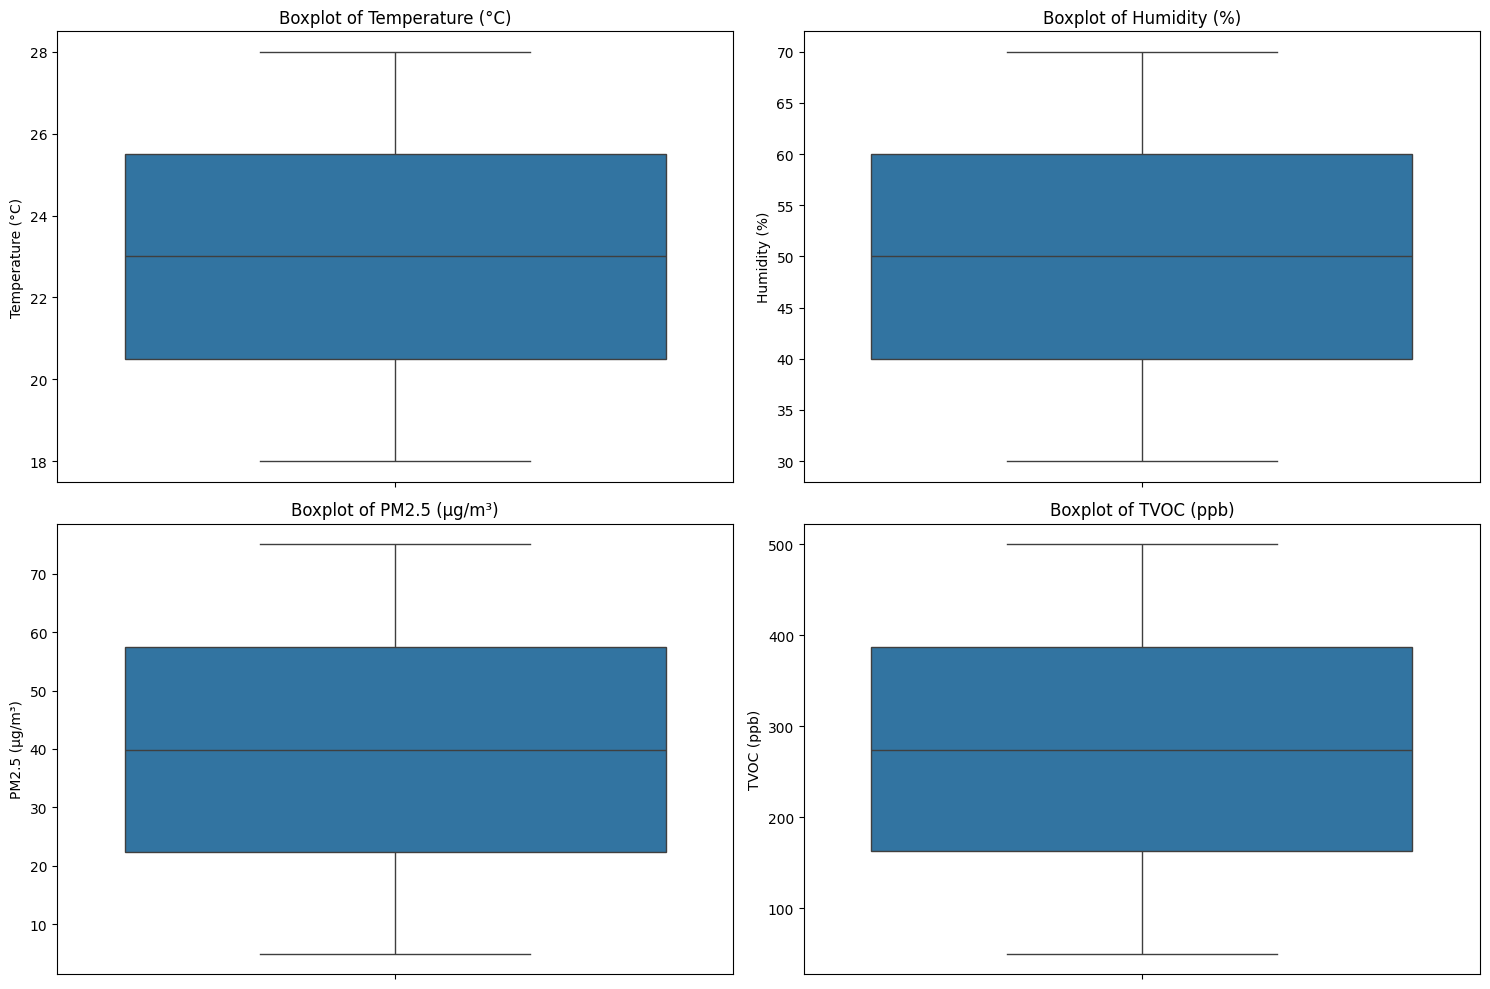

In [ ]:
# Memeriksa outlier
numerical_cols = df.select_dtypes(include=np.number).columns
print("Numerical Columns:", numerical_cols)

# Get numerical columns identified in the previous step
numerical_cols = df.select_dtypes(include=np.number).columns

# Determine the number of subplots needed
num_cols = len(numerical_cols)
num_rows = (num_cols + 1) // 2 # Adjust based on desired layout, e.g., 2 columns per row

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Generate boxplots for each numerical column
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)

# Remove any unused subplots if the number of numerical columns is odd
if num_cols < len(axes):
    for i in range(num_cols, len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Feature Scaling

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numerical_cols])
df_scaled = pd.DataFrame(df_scaled, columns=numerical_cols)
df_scaled.head()

,Temperature (°C),Humidity (%),PM2.5 (µg/m³),TVOC (ppb)
0,-0.431585,1.132065,-0.434738,-0.369594
1,1.565853,1.558174,-0.625287,-1.217583
2,0.806410,0.300632,1.677135,-1.681137
3,0.345197,0.734536,1.137659,-0.360118
4,-1.191027,1.671630,-0.662902,-0.058118


# Train & Evaluation

## DBSCAN

### Modelling

In [ ]:
# K Distance Graph
k = 7
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(df_scaled) # Menggunakan dataset X yang sudah ada
distances, indices = nbrs.kneighbors(df_scaled)

# Ambil jarak ke tetangga ke-k (kolom terakhir jika diurutkan)
k_distances = np.sort(distances[:, k-1], axis=0)

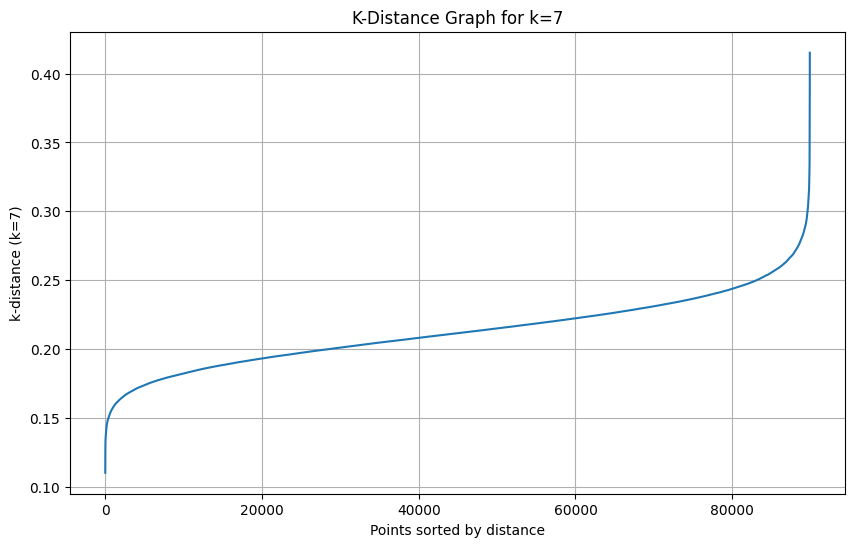

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"k-distance (k={k})")
plt.title(f"K-Distance Graph for k={k}")
plt.grid(True)
plt.show()

In [ ]:
epsilon = 0.25
minimumSamples = 8
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(df_scaled)
labels = db.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
core_samples_mask

array([ True,  True, False, ...,  True,  True,  True])

In [ ]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

4

In [ ]:
unique_labels = set(labels)
unique_labels

{np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3)}

### Cluster Visualisation

In [ ]:
# Inisialisasi PCA dengan 2 komponen
pca_dbscan = PCA(n_components=2)

# Terapkan PCA pada df_scaled, mengecualikan kolom 'Cluster'
df_pca_dbscan = pca_dbscan.fit_transform(df_scaled)

# Buat DataFrame baru dari hasil PCA
df_pca_dbscan = pd.DataFrame(df_pca_dbscan, columns=['PC1', 'PC2'])

# Tambahkan kembali kolom 'Cluster' dari df_scaled
df_pca_dbscan['Cluster'] = pd.DataFrame(db.labels_, columns=['Cluster'])

print("PCA dimensionality reduction completed and clusters assigned.")
display(df_pca_dbscan.head())

PCA dimensionality reduction completed and clusters assigned.


,PC1,PC2,Cluster
0,0.026629,-0.875424,0
1,0.473721,-1.778704,0
2,-0.203008,0.838264,0
3,0.586587,0.478988,0
4,0.130465,-1.121013,0


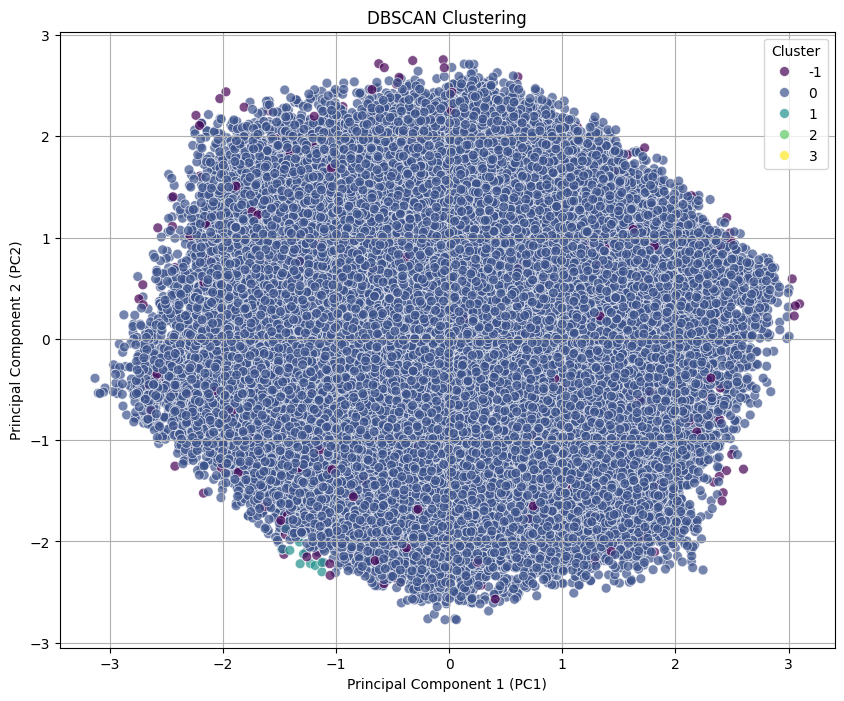

Cluster visualization using PCA completed.


In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca_dbscan, palette='viridis', s=50, alpha=0.7)
plt.title('DBSCAN Clustering')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
print("Cluster visualization using PCA completed.")

## KMeans

In [ ]:
# Menentukan jumlah cluster optimal
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(df_scaled)
    inertia_values.append(kmeans.inertia_)
print("Inertia values calculated successfully.")

Inertia values calculated successfully.


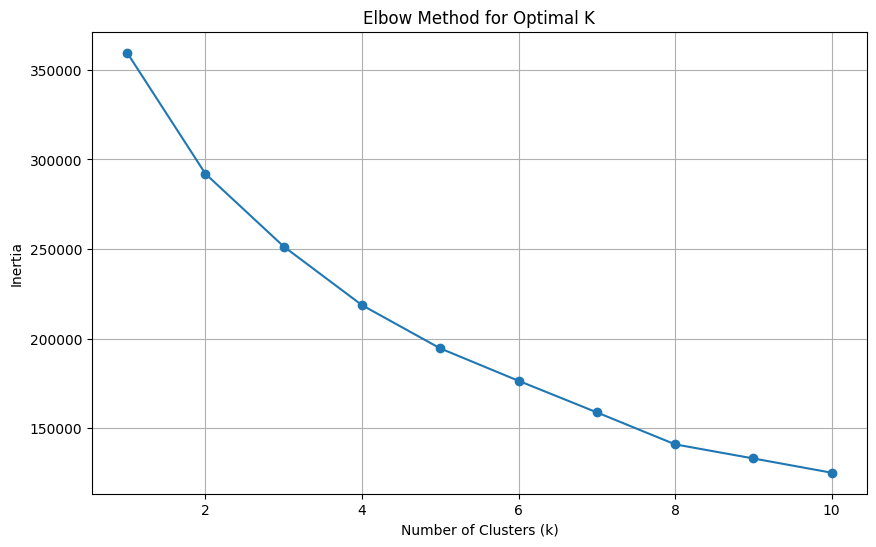

In [ ]:
k_values = range(1, 11)
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans.fit(df_scaled)
df_scaled['Cluster'] = kmeans.labels_
df['Cluster'] = kmeans.labels_

print("K-Means model trained and cluster labels assigned.")
display(df_scaled.head())
display(df.head())

K-Means model trained and cluster labels assigned.


,Temperature (°C),Humidity (%),PM2.5 (µg/m³),TVOC (ppb),Cluster
0,-0.431585,1.132065,-0.434738,-0.369594,2
1,1.565853,1.558174,-0.625287,-1.217583,2
2,0.806410,0.300632,1.677135,-1.681137,0
3,0.345197,0.734536,1.137659,-0.360118,0
4,-1.191027,1.671630,-0.662902,-0.058118,1


,Timestamp,Temperature (°C),Humidity (%),PM2.5 (µg/m³),TVOC (ppb),Cluster
0,18-02-2024 08:00,21.75,63.11,31.17,226.83,2
1,18-02-2024 08:05,27.51,68.03,27.32,116.76,2
2,18-02-2024 08:10,25.32,53.51,73.84,56.59,0
3,18-02-2024 08:15,23.99,58.52,62.94,228.06,0
4,18-02-2024 08:20,19.56,69.34,26.56,267.26,1


In [ ]:

silhouette_avg = silhouette_score(df_scaled.drop('Cluster', axis=1), kmeans.labels_)
print(f"The average Silhouette Score is: {silhouette_avg:.2f}")

The average Silhouette Score is: 0.17


In [ ]:
print("df head with Cluster column:")
display(df.head())
print("df_scaled head with Cluster column:")
display(df_scaled.head())

df head with Cluster column:


,Timestamp,Temperature (°C),Humidity (%),PM2.5 (µg/m³),TVOC (ppb),Cluster
0,18-02-2024 08:00,21.75,63.11,31.17,226.83,2
1,18-02-2024 08:05,27.51,68.03,27.32,116.76,2
2,18-02-2024 08:10,25.32,53.51,73.84,56.59,0
3,18-02-2024 08:15,23.99,58.52,62.94,228.06,0
4,18-02-2024 08:20,19.56,69.34,26.56,267.26,1


df_scaled head with Cluster column:


,Temperature (°C),Humidity (%),PM2.5 (µg/m³),TVOC (ppb),Cluster
0,-0.431585,1.132065,-0.434738,-0.369594,2
1,1.565853,1.558174,-0.625287,-1.217583,2
2,0.806410,0.300632,1.677135,-1.681137,0
3,0.345197,0.734536,1.137659,-0.360118,0
4,-1.191027,1.671630,-0.662902,-0.058118,1


### Cluster Visualisation

In [ ]:
# Inisialisasi PCA dengan 2 komponen
pca = PCA(n_components=2)

# Terapkan PCA pada df_scaled, mengecualikan kolom 'Cluster'
df_pca = pca.fit_transform(df_scaled.drop('Cluster', axis=1))

# Buat DataFrame baru dari hasil PCA
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

# Tambahkan kembali kolom 'Cluster' dari df_scaled
df_pca['Cluster'] = df_scaled['Cluster']

print("PCA dimensionality reduction completed and clusters assigned.")
display(df_pca.head())

PCA dimensionality reduction completed and clusters assigned.


,PC1,PC2,Cluster
0,0.026629,-0.875424,2
1,0.473721,-1.778704,2
2,-0.203008,0.838264,0
3,0.586587,0.478988,0
4,0.130465,-1.121013,1


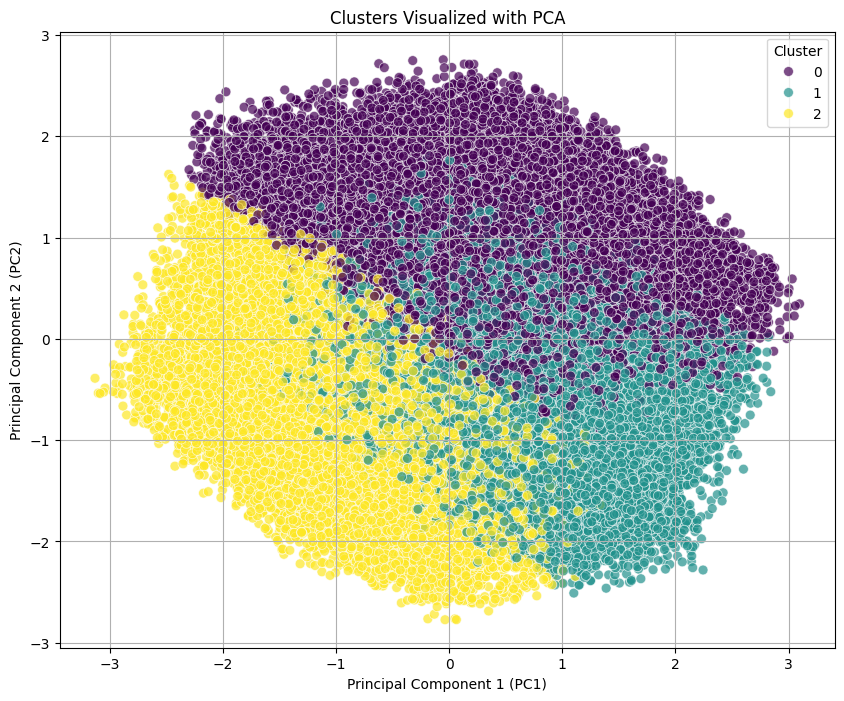

Cluster visualization using PCA completed.


In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=df_pca, palette='viridis', s=50, alpha=0.7)
plt.title('Clusters Visualized with PCA')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()
print("Cluster visualization using PCA completed.")

In [ ]:
cluster_characteristics = df.drop(columns=['Timestamp']).groupby('Cluster').mean()
print("Cluster characteristics (mean of original features):")
display(cluster_characteristics)

Cluster characteristics (mean of original features):


,Temperature (°C),Humidity (%),PM2.5 (µg/m³),TVOC (ppb)
Cluster,,,,
0,22.956387,50.091850,61.269508,276.323429
1,23.015450,50.458500,27.103189,394.675645
2,23.019357,49.560561,27.277243,154.440950
